In [2]:
import pandas as pd
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import TransformerConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.loader import DataLoader
import gpytorch
from gpytorch.mlls import DeepApproximateMLL, VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood
import os
import sys
import random
loger_dir = os.path.abspath('/home/ubuntu/project/mayang/LOGER')

# 将 QPE 目录添加到 sys.path
sys.path.append(loger_dir)
from core.models.DGP import DeepGPModel
from core.models.DKL import DKLGPModel
from sql import Sql, _global
from core import database, Sql, Plan, load
import ast
import re

# 获取 QPE 目录的绝对路径
qpe_dir = os.path.abspath('/home/ubuntu/project/mayang')

# 将 QPE 目录添加到 sys.path
sys.path.append(qpe_dir)

# 现在尝试导入 TreeBuilder 类
from QPE.sql2fea import TreeBuilder


def swap_join_condition(condition: str) -> str:
    '''防止同一个连接条件，左右连接条件不一样而无法识别'''
    # 找到等号的位置
    equal_index = condition.find('=')

    # 如果没有找到等号，返回原字符串
    if equal_index == -1:
        return condition

    # 拆分等号两边的条件，并去掉左右空格
    left_side = condition[:equal_index].strip()
    right_side = condition[equal_index + 1:].strip()

    # 交换等式两边的条件
    swapped_condition = f"{right_side} = {left_side}"

    return swapped_condition


def has_text_expression(cmp: str) -> bool:
    '''判断cmp中有没有文本'''
    # 使用正则表达式查找被引号包围的文本
    pattern = r"'[^']*'"

    # 查找匹配的内容
    match = re.search(pattern, cmp)

    # 如果找到了匹配内容，返回 True；否则返回 False
    return match is not None


def convert_between_expression(cmp: str) -> str:
    '''转换 BETWEEN 表达式'''
    match = re.match(r"([\w\.]+)\.(\w+)\s*BETWEEN\s*(.*)\s*AND\s*(.*)", cmp)

    if not match:
        raise ValueError("The input string is not a valid BETWEEN expression.")

    table_name, column, lower_bound, upper_bound = match.groups()

    # 检查值是否是数字
    if lower_bound.strip().isdigit() and upper_bound.strip().isdigit():
        new_expression = f"(({column} >= {lower_bound.strip()}) AND ({column} <= {upper_bound.strip()}))"
    else:
        new_expression = f"(({column})::text >= {lower_bound.strip()}::text) AND (({column})::text <= {upper_bound.strip()}::text)"

    return table_name, new_expression[:-1]


def convert_to_text_comparison(cmp: str):
    '''转化cmp与plan中的谓词表示, 处理 IN 语句。'''
    match_eq = re.match(r"([\w\.]+)\.(\w+)\s*(=|<>|<|>|<=|>=)\s*'(.*)'", cmp)
    match_in = re.match(r"([\w\.]+)\.(\w+)\s*IN\s*\((.*)\)", cmp, re.DOTALL)

    if match_eq:
        # 处理 '=' 比较
        table_name, column, operator, value = match_eq.groups()
        new_expression = f"(({column})::text {operator} '{value}'::text)"
        return table_name, new_expression
    elif match_in:
        # 处理 'IN' 比较
        table_name, column, values = match_in.groups()

        # 使用正则提取引号中的值，允许多行
        value_list = re.findall(r"'(.*?)'", values)
        if not value_list:
            raise ValueError("在 IN 表达式中未找到有效值。")

        # 检查是否存在嵌套括号
        if '(' in values or ')' in values:
            new_expression = f"(({column})::text = ANY ("
            return table_name, new_expression

        # 检查是否有值包含两个单词
        if len(value_list) > 1 and any(len(value.split()) > 1 for value in value_list):
            new_expression = f"(({column})::text = ANY ("
            return table_name, new_expression

        # 检查是否只有一个值
        if len(value_list) == 1:
            new_expression = f"(({column})::text = '{value_list[0]}'::text)"
        else:
            formatted_values = ','.join(value_list)  # 拼接多个值
            new_expression = f"(({column})::text = ANY ('{{{formatted_values}}}'::text[]))"

        return table_name, new_expression

    raise ValueError("输入字符串不是有效的比较表达式。")


def trim_parentheses_and_spaces(input_str: str) -> str:
    # 去除开头的空格
    trimmed_str = input_str.lstrip()
    # 如果开头是 '('，则去除它
    if trimmed_str.startswith('('):
        trimmed_str = trimmed_str[1:].lstrip()  # 去掉 '(' 以及后面的空格
    return trimmed_str


def transform_sql_like_condition(sql_condition):
    '''处理LIKE和NOT LIKE条件'''
    # 匹配 `AND` 和 `OR`
    sql_condition = trim_parentheses_and_spaces(sql_condition)
    conditions = re.split(r"(?i) AND | OR ", sql_condition)
    # print(conditions)

    # 转换每个 LIKE 和 NOT LIKE 条件为 Postgres 的格式
    transformed_clauses = []
    for condition in conditions:
        condition = condition.strip()
        table_name = condition.split('.')[0]
        col_name = condition.split()[0][len(table_name) + 1:]
        if 'not like' in condition.lower():
            transformed_clause = f"(({col_name})::text !~~ {condition.split('not like')[1].strip().rstrip(')')}::text)"
        elif 'like' in condition.lower():
            transformed_clause = f"(({col_name})::text ~~ {condition.split('like')[1].strip().rstrip(')')}::text)"
            # print("condition.split('like')[1].strip()",condition.split('like')[1].strip())
        else:
            continue

        transformed_clauses.append(transformed_clause)

    # 返回表名和第一个转换后的条件
    return table_name, transformed_clauses[0]


def delete_left_table_cond(sql_condition):
    # 使用正则表达式匹配表名和列名
    match = re.match(r"[\w\.]+\.(\w+)\s*=\s*(.*)", sql_condition)

    if not match:
        raise ValueError("The input string is not a valid comparison expression.")

    # 提取列名和右侧表达式
    column = match.group(1)
    right_side = match.group(2)

    return f"{column} = {right_side.strip()}"


def dgl_node_and_edge_vectorization(sql_query, config_index, plan):
    sql_instance = Sql(sql_query)

    # 构建异构图
    g, data_dict, node_indexes, edge_list = sql_instance.to_hetero_graph_dgl()
    # 构建 node feature
    filter_features = g.ndata['filter']
    edge_features = g.ndata['edge']
    onehot_features = g.ndata['onehot']
    others_features = g.ndata['others'].view(g.ndata['filter'].shape[0], -1)

    # 假设两个特征的维度是相同的
    combined_features = torch.cat((filter_features, edge_features,onehot_features,others_features), dim=1)
    g.ndata['feature'] = combined_features

    # 构建 edge feature
    tree_builder = TreeBuilder()
    tree_builder.set_configruations(config_index)
    tree_builder.set_table_to_alias_dict(sql_query)
    # 准备您的 SQL 执行计划数据，这里是一个示例
    execution_plan = ast.literal_eval(plan)[0]['Plan']

    # 特征化执行计划
    features = tree_builder.plan_to_feature_tree(execution_plan, current_height=0)

    # 提取对应operator vector
    operator_vector_dict = tree_builder.get_operator_vector()
    # 建立cmp与plan_operator的映射关系
    tables = []
    operator_vectors_cmp1 = []
    operator_vectors_cmp2 = []
    get_keys = []
    for cmp, table_num in edge_list:
        flag = False
        # print('cmp:',cmp)
        if table_num == 1:
            if 'like' in cmp and has_text_expression(cmp):
                try:
                    table, cmp_in_op = transform_sql_like_condition(cmp)
                except:
                    print('error process like_cmp:', cmp)
            elif 'BETWEEN' in cmp:
                table, cmp_in_op = convert_between_expression(cmp)
            elif has_text_expression(cmp):
                table, cmp_in_op = convert_to_text_comparison(cmp)
            else:
                table, cmp_in_op = cmp.split('.')

        for key in operator_vector_dict:
            if table_num == 1:
                table_op, key_op = key.split('_47_')
                if cmp_in_op in key and table == table_op:
                    tables.append(table)
                    operator_vectors_cmp1.append(operator_vector_dict[key])
                    flag = True
                    break
            # print(key)
            elif cmp in key or swap_join_condition(cmp) in key or delete_left_table_cond(
                    cmp) in key or delete_left_table_cond(swap_join_condition(cmp)) in key:
                get_keys.append(cmp)
                operator_vectors_cmp2.append(operator_vector_dict[key])
                operator_vectors_cmp2.append(operator_vector_dict[key])
                flag = True
                break
        if not flag:
            # 存在plan中不存在的cmp
            print('error cmp', cmp)
            if table_num == 2:
                print('add edge vector:', table_num)
                operator_vectors_cmp2.append(torch.zeros((1, num_edge_features)))
                operator_vectors_cmp2.append(torch.zeros((1, num_edge_features)))
    # print('cmp',len(edge_list))
    # print(len(operator_vectors_cmp1),len(operator_vectors_cmp2))
    # 合并每一条边的向量
    vector_cmp1 = torch.cat(operator_vectors_cmp1, dim=0)
    vector_cmp2 = torch.cat(operator_vectors_cmp2, dim=0)
    vector_edge = torch.cat((vector_cmp2, vector_cmp1), dim=0)
    # 添加自环
    for t in tables:
        new_u = torch.tensor([node_indexes['~' + t]])  # 自环的起点
        new_v = torch.tensor([node_indexes['~' + t]])  # 自环的终点
        g.add_edges(new_u, new_v)
    g.edata['feature'] = vector_edge
    return g


def dgl_to_pyg(dgl_graph):
    """将 DGL 图转换为 PyG 格式."""
    x = dgl_graph.ndata['feature']  # 节点特征
    edge_index = torch.stack(dgl_graph.edges()).long()  # 边索引 (转换为 PyG 格式)
    edge_attr = dgl_graph.edata['feature']  # 边特征
    batch = torch.zeros(dgl_graph.number_of_nodes(), dtype=torch.long)  # 所有节点归为同一批次
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)


class GraphEncoder(nn.Module):
    """图编码模块，基于 TransformerConv."""

    def __init__(self, in_feats, edge_feats, embedding_size, num_layers=3, top_k_every_n=3, top_k_ratio=0.5, n_heads=4,
                 dropout_rate=0.5):
        super(GraphEncoder, self).__init__()
        self.embedding_size = embedding_size
        self.top_k_every_n = top_k_every_n
        self.edge_dim = edge_feats
        self.n_heads = n_heads

        # 第一层 TransformerConv
        self.conv1 = TransformerConv(in_feats, self.embedding_size, heads=n_heads, dropout=dropout_rate,
                                     edge_dim=edge_feats, beta=True)
        self.transf1 = nn.Linear(self.embedding_size * n_heads, self.embedding_size)
        self.bn1 = nn.BatchNorm1d(self.embedding_size)

        # 其他 TransformerConv 层及 TopKPooling
        # TopKPooling 需要对图进行下采样，类似于卷积神经网络（CNN）中的池化操作，用来减小图的大小，保留最重要的信息。
        self.conv_layers = nn.ModuleList()
        self.transf_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.pooling_layers = nn.ModuleList()

        for _ in range(num_layers):
            self.conv_layers.append(
                TransformerConv(self.embedding_size, self.embedding_size, heads=n_heads, dropout=dropout_rate,
                                edge_dim=edge_feats, beta=True))
            self.transf_layers.append(nn.Linear(self.embedding_size * n_heads, self.embedding_size))
            self.bn_layers.append(nn.BatchNorm1d(self.embedding_size))
            self.pooling_layers.append(TopKPooling(self.embedding_size, ratio=top_k_ratio))

    def forward(self, x, edge_attr, edge_index, batch_index):
        x = self.conv1(x, edge_index, edge_attr)

        # 调整线性层输入的形状
        x = torch.relu(self.transf1(x.view(-1, self.embedding_size * self.n_heads)))
        x = self.bn1(x)

        global_representation = []

        for i, conv_layer in enumerate(self.conv_layers):
            x = conv_layer(x, edge_index, edge_attr)
            x = torch.relu(self.transf_layers[i](x.view(-1, self.embedding_size * self.n_heads)))  # 确保形状匹配
            x = self.bn_layers[i](x)

            if i % self.top_k_every_n == 0 or i == len(self.conv_layers) - 1:
                x, edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[i](
                    x, edge_index, edge_attr, batch_index
                )
                global_representation.append(torch.cat([
                    gmp(x, batch_index),
                    gap(x, batch_index)
                ], dim=1))

        x = sum(global_representation)

        return x


class ImprovementPredictionModel(nn.Module):
    """预测模型，基于图编码."""

    def __init__(self, in_feats, edge_feats, graph_embedding_size, use_dgp=True):
        print('start ImprovementPredictionModel')
        super(ImprovementPredictionModel, self).__init__()
        self.use_dgp = use_dgp
        self.graph_encoder = GraphEncoder(in_feats, edge_feats, graph_embedding_size)

        # 定义高斯过程模型和对应的似然函数
        self.likelihood = GaussianLikelihood()
        if self.use_dgp:
            self.gp_model = DeepGPModel(
                graph_embedding_size * 2)  # 2 * graph_embedding_size 是因为我们在全局池化时合并了 mean 和 max 结果
        else:
            self.gp_model = DKLGPModel(graph_embedding_size * 2)

    def forward(self, x, edge_attr, edge_index, batch_index):
        graph_embedding = self.graph_encoder(x, edge_attr, edge_index, batch_index)

        # 确保在训练时调用 train()，在预测时调用 eval()
        self.gp_model.train()
        self.likelihood.train()

        with gpytorch.settings.fast_pred_var():
            # 使用 graph_embedding 进行预测
            output = self.gp_model(graph_embedding)
            prediction = self.likelihood(output)

        return prediction  # 返回高斯过程的均值作为预测值

    def predict(self, x, edge_attr, edge_index, batch_index):
        """在预测时调用"""
        graph_embedding = self.graph_encoder(x, edge_attr, edge_index, batch_index)
        self.gp_model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var():
            output = self.gp_model(graph_embedding)
            prediction = self.likelihood(output)

        return prediction


def load_sql_graphs_pyg(csv_path, dbname, user, password, host, port, start_idx=0, end_idx=8935):
    """
    从指定的 CSV 文件加载 SQL 查询，并将它们转换为 PyG 图数据。

    参数:
    - csv_path (str): CSV 文件路径。
    - dbname (str): 数据库名称。
    - user (str): 数据库用户。
    - password (str): 数据库密码。
    - host (str): 数据库主机地址。
    - port (str): 数据库端口。
    - start_idx (int): SQL 查询的起始索引。
    - end_idx (int): SQL 查询的结束索引。

    返回:
    - sql_graphs_pyg (list): PyG 数据列表。
    """
    print('start load_sql_graphs_pyg')
    # 读取 CSV 数据
    df = pd.read_csv(csv_path).iloc[start_idx:end_idx, :]
    # 设置数据库连接
    database.setup(dbname=dbname, user=user, password=password, host=host, port=port, cache=False)
    sql_graphs_pyg = []
    print('df.columns',df.columns)
    df_id=df['Unnamed: 0'].values

    query_list = df['query'].values
    quey_config_list = df['index'].values
    query_plans = df['query_plan_no_index'].values
    for i in range(df.shape[0]):
        # if cnt % 50 == 0:
        #     print(cnt)
        print(i,df_id[i])
        g = dgl_node_and_edge_vectorization(query_list[i], quey_config_list[i], query_plans[i])
        # 转换为 PyG 数据
        pyg_data = dgl_to_pyg(g)
        sql_graphs_pyg.append(pyg_data)

    return sql_graphs_pyg, df['improvement'].values

num_edge_features = 49

    # 读取数据并设置数据库
sql_graphs_pyg, label_list = load_sql_graphs_pyg(
        csv_path='/home/ubuntu/project/mayang/Classification/process_data/job/job_train_8935.csv',
        dbname='imdbload',
        user='postgres',
        password='password',
        host='127.0.0.1',
        port='5432',
        start_idx=7,
        end_idx=39
    )
print('len(label_list) 需要是batch_size的倍数', len(label_list))
# 创建 PyG DataLoader
data_loader = DataLoader(sql_graphs_pyg, batch_size=32, shuffle=True)

start load_sql_graphs_pyg
{'dbname': 'imdbload', 'user': 'postgres', 'password': 'password', 'host': '127.0.0.1', 'port': '5432', 'cache': False}
<connection object at 0x7f25ed0dd2c0; dsn: 'user=postgres password=xxx dbname=imdbload host=127.0.0.1 port=5432', closed: 0>
<cursor object at 0x7f25ed0b74f0; closed: 0>
df.columns Index(['Unnamed: 0', 'query', 'index', 'c0', 'c1', 't0', 't1', 'error',
       'improvement', 'query_plan_no_index', 'query_plan_index'],
      dtype='object')
0 7
error cmp mc.movie_id = t.id
add edge vector: 2
1 8
error cmp mc.movie_id = t.id
add edge vector: 2
2 9
error cmp mc.movie_id = t.id
add edge vector: 2
3 10
error cmp mc.movie_id = t.id
add edge vector: 2
4 11
error cmp mc.movie_id = t.id
add edge vector: 2
5 12
error cmp mc.movie_id = t.id
add edge vector: 2
6 13
error cmp mc.movie_id = t.id
add edge vector: 2
7 14
error cmp mc.movie_id = t.id
add edge vector: 2
8 15
error cmp mc.movie_id = t.id
add edge vector: 2
9 16
error cmp mc.movie_id = t.id
add e

In [19]:
sql_graphs_pyg[1]['x']

tensor([[0.0000, 0.0000, 0.0090,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0088, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
graph_embedding_list=[]
class ImprovementPredictionModelGNN(nn.Module):
    """使用图卷积神经网络进行预测，基于图编码，并增加多层线性层."""
    
    def __init__(self, in_feats, edge_feats, graph_embedding_size, hidden_dim=128, num_layers=3):
        print('start ImprovementPredictionModel')
        super(ImprovementPredictionModelGNN, self).__init__()
        self.graph_encoder = GraphEncoder(in_feats, edge_feats, graph_embedding_size)
        
        # 定义多个全连接层
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()  # 批归一化层列表
        
        # 第一层，从图嵌入维度到隐藏层维度
        self.layers.append(nn.Linear(graph_embedding_size * 2, hidden_dim))  # 2 * graph_embedding_size 因为全局池化时合并了 mean 和 max
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))  # 添加批归一化层

        # 中间的隐藏层
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        
        # 最后一层，隐藏层到输出维度
        self.layers.append(nn.Linear(hidden_dim, 1))  # 输出为单个值
        
    def forward(self, x, edge_attr, edge_index, batch_index):
        # 通过图编码器获取图的嵌入表示
        graph_embedding = self.graph_encoder(x, edge_attr, edge_index, batch_index)
        graph_embedding_list.append(graph_embedding)
        
        # 将嵌入表示输入到多层全连接网络
        for i, layer in enumerate(self.layers[:-1]):
            graph_embedding = layer(graph_embedding)  # 全连接层
            graph_embedding = self.batch_norms[i](graph_embedding)  # 批归一化层
            graph_embedding = F.relu(graph_embedding)  # ReLU 激活函数
        
        # 最后一层输出预测值
        output = self.layers[-1](graph_embedding)
        prediction = F.relu(output)  # 使用 ReLU 激活函数保证输出非负数
        
        return prediction
    
    def predict(self, x, edge_attr, edge_index, batch_index):
        """在预测时调用"""
        # self.eval()  # 设置为评估模式
        with torch.no_grad():
            graph_embedding = self.graph_encoder(x, edge_attr, edge_index, batch_index)
            
            # 通过多层全连接网络计算预测值
            for i, layer in enumerate(self.layers[:-1]):
                graph_embedding = layer(graph_embedding)
                graph_embedding = self.batch_norms[i](graph_embedding)
                graph_embedding = F.relu(graph_embedding)
                
            output = self.layers[-1](graph_embedding)
            prediction = F.relu(output)  # 保证预测值为非负数
            
        return prediction


In [7]:
model = ImprovementPredictionModelGNN(sql_graphs_pyg[0].x.shape[1], sql_graphs_pyg[0].edge_attr.shape[1],
                                       graph_embedding_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()  # 均方误差损失函数

start ImprovementPredictionModel


In [8]:
import numpy as np
print('start DeepApproximateMLL')
# mll = DeepApproximateMLL(VariationalELBO(model.gp_model.likelihood, model.gp_model, 32))
for epoch in range(10):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(data_loader):
        # 前向传播
        with gpytorch.settings.num_likelihood_samples(data_loader.batch_size):
            pred_time = model(batch.x, batch.edge_attr, batch.edge_index, batch.batch)

            target = torch.tensor(
                label_list[batch_idx * data_loader.batch_size:(batch_idx + 1) * data_loader.batch_size],
                dtype=torch.float).view(-1, 1)

            loss = criterion(pred_time, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        print("Epoch %d batch_idx%d loss:" % (epoch + 1, batch_idx), loss.item())

    print(f'Epoch {epoch + 1}, Loss: {total_loss:.4f}')

    # 随机抽取 20 个样本进行预测
    sample_indices = random.sample(range(len(sql_graphs_pyg)), 20)
    for idx in sample_indices:
        sample_batch = sql_graphs_pyg[idx]
        sample_x = sample_batch.x
        sample_edge_attr = sample_batch.edge_attr
        sample_edge_index = sample_batch.edge_index

            # 获取对应的 target 值
        target_value = label_list[idx]
        model.eval()
        with torch.no_grad():
            with gpytorch.settings.num_likelihood_samples(32):
                pred_mean = model.predict(sample_x, sample_edge_attr, sample_edge_index, sample_batch.batch)
        print(f'Sample Index: {idx}, Predicted Mean: {pred_mean}, Target Value: {target_value}')

start DeepApproximateMLL
Epoch 1 batch_idx0 loss: 0.383228063583374
Epoch 1, Loss: 0.3832
Sample Index: 23, Predicted Mean: tensor([[0.0507]]), Target Value: 0.9129199204758888
Sample Index: 9, Predicted Mean: tensor([[0.0507]]), Target Value: 0.5093801947280931
Sample Index: 26, Predicted Mean: tensor([[0.0457]]), Target Value: 0.9263342171526364
Sample Index: 25, Predicted Mean: tensor([[0.0456]]), Target Value: 0.922907536538503
Sample Index: 7, Predicted Mean: tensor([[0.0507]]), Target Value: -0.1172862887635885
Sample Index: 5, Predicted Mean: tensor([[0.0507]]), Target Value: -0.1175433879391047
Sample Index: 27, Predicted Mean: tensor([[0.0511]]), Target Value: 0.9239889231469725
Sample Index: 13, Predicted Mean: tensor([[0.0507]]), Target Value: 0.91265889612212
Sample Index: 10, Predicted Mean: tensor([[0.0507]]), Target Value: 0.4933556545136606
Sample Index: 12, Predicted Mean: tensor([[0.0507]]), Target Value: 0.8769868761665138
Sample Index: 15, Predicted Mean: tensor([[0

In [11]:
# 假设 GraphEncoder 是模型的一部分
# 在执行 loss.backward() 之后检查每个参数的梯度
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} grad: {param.grad.mean()}")
    else:
        print(f"{name} grad is None")

graph_encoder.conv1.lin_key.weight grad: -4.236565871451603e-07
graph_encoder.conv1.lin_key.bias grad: -1.2824959193594165e-12
graph_encoder.conv1.lin_query.weight grad: 2.58596326574434e-08
graph_encoder.conv1.lin_query.bias grad: -7.106262955858256e-07
graph_encoder.conv1.lin_value.weight grad: 4.4942984800400154e-07
graph_encoder.conv1.lin_value.bias grad: 1.626149014555267e-06
graph_encoder.conv1.lin_edge.weight grad: 5.835407137055881e-06
graph_encoder.conv1.lin_skip.weight grad: 4.848671596846543e-05
graph_encoder.conv1.lin_skip.bias grad: 6.300666427705437e-05
graph_encoder.conv1.lin_beta.weight grad: -8.020637324079871e-05
graph_encoder.transf1.weight grad: -0.0005682318587787449
graph_encoder.transf1.bias grad: -0.0014440176310017705
graph_encoder.bn1.weight grad: 0.0005119011038914323
graph_encoder.bn1.bias grad: 0.009684782475233078
graph_encoder.conv_layers.0.lin_key.weight grad: -7.1030094659363385e-06
graph_encoder.conv_layers.0.lin_key.bias grad: 6.106335576072652e-11
gr

In [13]:
for group in optimizer.param_groups:
    for param in group['params']:
        print(param.shape, param.requires_grad)

torch.Size([128, 180]) True
torch.Size([128]) True
torch.Size([128, 180]) True
torch.Size([128]) True
torch.Size([128, 180]) True
torch.Size([128]) True
torch.Size([128, 49]) True
torch.Size([128, 180]) True
torch.Size([128]) True
torch.Size([1, 384]) True
torch.Size([32, 128]) True
torch.Size([32]) True
torch.Size([32]) True
torch.Size([32]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([128, 49]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([1, 384]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([128, 49]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([1, 384]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([128, 32]) True
torch.Size([128]) True
torch.Size([128, 32]) True
torch.Size([128])

In [9]:
# 随机抽取 20 个样本进行预测
sample_indices = random.sample(range(len(sql_graphs_pyg)), 200)
for idx in sample_indices:
    sample_batch = sql_graphs_pyg[idx]
    sample_x = sample_batch.x
    sample_edge_attr = sample_batch.edge_attr
    sample_edge_index = sample_batch.edge_index

            # 获取对应的 target 值
    target_value = label_list[idx]
    # model.eval()
    with torch.no_grad():
        with gpytorch.settings.num_likelihood_samples(32):
            pred_mean = model.predict(sample_x, sample_edge_attr, sample_edge_index, sample_batch.batch)
    print(f'Sample Index: {idx}, Predicted Mean: {pred_mean}, Target Value: {target_value}')

ValueError: Sample larger than population or is negative

## TEST

In [7]:
for idx in [1,2,4645,24,3898,676,243,2454]:
    sample_batch = sql_graphs_pyg[idx]
    sample_x = sample_batch.x
    sample_edge_attr = sample_batch.edge_attr
    sample_edge_index = sample_batch.edge_index

            # 获取对应的 target 值
    target_value = label_list[idx]
    model.eval()
    with torch.no_grad():
        with gpytorch.settings.num_likelihood_samples(32):
            pred_mean = model.predict(sample_x, sample_edge_attr, sample_edge_index, sample_batch.batch)
    print(f'Sample Index: {idx}, Predicted Mean: {np.mean(pred_mean.mean.numpy())}, Target Value: {target_value}')

Sample Index: 1, Predicted Mean: -1.0, Target Value: -0.7784686092591014
Sample Index: 2, Predicted Mean: -1.0, Target Value: -0.7749570081760407
Sample Index: 4645, Predicted Mean: -1.0, Target Value: 0.4244834935572047
Sample Index: 24, Predicted Mean: -0.9999998807907104, Target Value: -0.8210903098154072
Sample Index: 3898, Predicted Mean: -1.0, Target Value: -0.94082010622178
Sample Index: 676, Predicted Mean: -0.9999997615814209, Target Value: -0.4294899191883906
Sample Index: 243, Predicted Mean: -0.9999999403953552, Target Value: -0.1145089466477217
Sample Index: 2454, Predicted Mean: -1.0, Target Value: -0.424734912188394


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MultivariateNormal(loc: torch.Size([20])) tensor([ 0.2404,  0.3629,  0.8490,  0.4967,  1.1968,  1.2601,  0.8687,  0.7079,
         0.5427,  0.2736,  0.1118, -0.3947, -1.0377, -0.9369, -0.8527, -0.9951,
        -1.1147, -0.7697, -0.3562,  0.1098])
Iter 1/500 - Loss: 1.292   lengthscale: 0.693   noise: 0.693
MultivariateNormal(loc: torch.Size([20])) tensor([ 0.2404,  0.3629,  0.8490,  0.4967,  1.1968,  1.2601,  0.8687,  0.7079,
         0.5427,  0.2736,  0.1118, -0.3947, -1.0377, -0.9369, -0.8527, -0.9951,
        -1.1147, -0.7697, -0.3562,  0.1098])
Iter 2/500 - Loss: 1.263   lengthscale: 0.826   noise: 0.576
MultivariateNormal(loc: torch.Size([20])) tensor([ 0.2404,  0.3629,  0.8490,  0.4967,  1.1968,  1.2601,  0.8687,  0.7079,
         0.5427,  0.2736,  0.1118, -0.3947, -1.0377, -0.9369, -0.8527, -0.9951,
        -1.1147, -0.7697, -0.3562,  0.1098])
Iter 3/500 - Loss: 1.199   lengthscale: 0.974   n

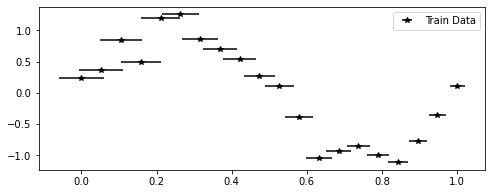

In [8]:
import math
import torch
import tqdm
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x_mean = torch.linspace(0, 1, 20)
# We'll assume the variance shrinks the closer we get to 1
train_x_stdv = torch.linspace(0.03, 0.01, 20)

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x_mean * (2 * math.pi)) + torch.randn(train_x_mean.size()) * 0.2

train_x_distributional = torch.stack((train_x_mean, (train_x_stdv**2).log()), dim=1)

f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(train_x_mean, train_y, xerr=(train_x_stdv * 2), fmt="k*", label="Train Data")
ax.legend()

from gpytorch.models import ExactGP
from gpytorch.kernels import GaussianSymmetrizedKLKernel, ScaleKernel
from gpytorch.means import ConstantMean

class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(GaussianSymmetrizedKLKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x_distributional, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.25)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x_distributional)
    print(output,train_y)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

In [9]:
train_x_mean

tensor([0.0000, 0.0526, 0.1053, 0.1579, 0.2105, 0.2632, 0.3158, 0.3684, 0.4211,
        0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895, 0.8421, 0.8947,
        0.9474, 1.0000])

In [10]:
train_x_distributional

tensor([[ 0.0000, -7.0131],
        [ 0.0526, -7.0846],
        [ 0.1053, -7.1586],
        [ 0.1579, -7.2356],
        [ 0.2105, -7.3156],
        [ 0.2632, -7.3989],
        [ 0.3158, -7.4859],
        [ 0.3684, -7.5768],
        [ 0.4211, -7.6721],
        [ 0.4737, -7.7721],
        [ 0.5263, -7.8774],
        [ 0.5789, -7.9885],
        [ 0.6316, -8.1062],
        [ 0.6842, -8.2312],
        [ 0.7368, -8.3646],
        [ 0.7895, -8.5075],
        [ 0.8421, -8.6615],
        [ 0.8947, -8.8282],
        [ 0.9474, -9.0102],
        [ 1.0000, -9.2103]])